In [78]:
import numpy as np
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim import corpora, models
from gensim.models import CoherenceModel
from pprint import pprint

# Load the dataset
df = pd.read_csv("C:/Users/mrina/Desktop/indeed cleaned.csv")

In [79]:
# Data cleaning
# Remove any rows with missing values
df = df.dropna(subset=['description_text'])

# Convert all text to lowercase
df['description_text'] = df['description_text'].apply(lambda x: x.lower())

# Remove any URLs from the text
df['description_text'] = df['description_text'].apply(lambda x: re.sub(r'http\S+', '', x))
# Remove any non-alphabetic characters
df['description_text'] = df['description_text'].apply(lambda x: re.sub(r'[^a-zA-Z]', ' ', x))

# Tokenize the text

df['description_text'] = df['description_text'].apply(lambda x: nltk.word_tokenize(x))

# Remove stop words
stop_words = set(stopwords.words('english'))
df['description_text'] = df['description_text'].apply(lambda x: [word for word in x if word not in stop_words])

# Lemmatize the words
lemmatizer = WordNetLemmatizer()
df['description_text'] = df['description_text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Remove short words
df['description_text'] = df['description_text'].apply(lambda x: [word for word in x if len(word) > 3])

# Remove rare and common words
dictionary = corpora.Dictionary(df['description_text'])
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in df['description_text']]

# Train multiple LDA models and select the best one
num_topics_list = [13,20,21,24]
passes_list = [5, 10]

best_model = None
best_coherence_score = -float('inf')
best_perplexity = float('inf')

for num_topics in num_topics_list:
    for passes in passes_list:
        lda_model = models.LdaMulticore(corpus=corpus,
                                        id2word=dictionary,
                                        num_topics=num_topics,
                                        passes=passes,
                                        workers=5)

        # Compute coherence score
        coherence_model = CoherenceModel(model=lda_model, texts=df['description_text'], dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()

        # Compute perplexity
        perplexity = lda_model.log_perplexity(corpus)

        # Update the best model
        if coherence_score > best_coherence_score and perplexity < best_perplexity:
            best_model = lda_model
            best_coherence_score = coherence_score
            best_perplexity = perplexity
            best_topic=num_topics

best_model.save('C:/Users/mrina/Downloads/lda_model')
# Print the best model and evaluation metrics
print('Best LDA model:\n')
print(f'Number of Topics: {best_topic}')
pprint(best_model.show_topics())
print(f'Coherence score: {best_coherence_score:.4f}')
print(f'Perplexity: {best_perplexity:.4f}')

Best LDA model:

Number of Topics: 13.0000
[(9,
  '0.008*"architecture" + 0.007*"cloud" + 0.006*"health" + 0.006*"software" + '
  '0.005*"across" + 0.005*"people" + 0.005*"product" + 0.005*"covid" + '
  '0.004*"practice" + 0.004*"gender"'),
 (12,
  '0.007*"testing" + 0.006*"software" + 0.006*"engineer" + 0.005*"product" + '
  '0.005*"implementation" + 0.004*"infrastructure" + 0.004*"architecture" + '
  '0.004*"cloud" + 0.004*"firewall" + 0.004*"best"'),
 (2,
  '0.033*"cloud" + 0.009*"azure" + 0.007*"infrastructure" + '
  '0.007*"architecture" + 0.005*"platform" + 0.005*"access" + '
  '0.004*"enterprise" + 0.004*"servicenow" + 0.004*"automation" + '
  '0.004*"engineer"'),
 (5,
  '0.020*"remote" + 0.015*"cloud" + 0.008*"product" + 0.007*"architecture" + '
  '0.006*"software" + 0.006*"best" + 0.005*"people" + 0.005*"make" + '
  '0.004*"enterprise" + 0.004*"better"'),
 (3,
  '0.005*"applicant" + 0.005*"accommodation" + 0.005*"individual" + '
  '0.005*"compliance" + 0.004*"software" + 0.004

In [90]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Create the visualization
vis = gensimvis.prepare(best_model, corpus, dictionary)

# Display the visualization
pyLDAvis.display(vis)

C:\Users\mrina\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [91]:
pyLDAvis.save_html(vis, 'C:/Users/mrina/Downloads/my_lda_vis_indeed.html')

In [83]:
# Get the dominant topic for each document
topic_distribution = [best_model[doc] for doc in corpus]
df['dominant_topic'] = [max(doc_topic_prob, key=lambda x: x[1])[0] for doc_topic_prob in topic_distribution]

# Get the top 10 job titles by count for each topic
top_job_titles_by_topic = {}
for topic in range(best_topic):
    # Get the job titles for this topic
    topic_docs = df[df['dominant_topic'] == topic]
    job_titles = topic_docs['job_title'].value_counts()[:10]
    
    # Add the job titles for this topic to the dictionary
    top_job_titles_by_topic[f'Topic {topic+1}'] = list(job_titles.index)

# Print the top job titles for each topic
for topic, job_titles in top_job_titles_by_topic.items():
    print(f'{topic}:')
    print(job_titles)

Topic 1:
['Information Security Analyst', 'Cyber Security Analyst', 'Cybersecurity Analyst', 'Cyber Security Engineer', 'Security Engineer', 'IT Security Analyst', 'Information Systems Security Officer (ISSO)', 'Cyber Security Architect', 'Information Security Officer', 'Information Security Manager']
Topic 2:
['Lead Cyber Data Protection Analyst', 'Sr. IT Security Analyst, REMOTE from any US based location in central or eastern time zones', 'Financial Services Cybersecurity Senior Staff', 'Application Security Engineer - Remote', 'Industrial Cybersecurity Consultant (NIST) - 1898 & Co. (Multiple Locations)', 'Associate Director of Cybersecurity GRC Remote', 'Cyber Security Engineer', 'Remote Cybersecurity GRC Analyst II', 'Remote Cybersecurity GRC Analyst III', 'Penetration Testing Manager']
Topic 3:
['Manager, Cloud Security Engineer', 'Foundry Cyber SOAR Manager', 'Foundry Cyber SOAR Senior Consultant', 'Cloud Security Engineer', 'Cloud Security Architect', 'Cyber Security Engineer'

In [87]:
topics = best_model.show_topics(num_topics=-1, num_words=25)

for topic in topics:
    topic_num = topic[0]
    words = [word[0] for word in lda_model.show_topic(topic_num, topn=25)]
    print(f"Topic {topic_num+1}: {','.join(words)}")

Topic 1: benefit,please,health,federal,education,apply,resume,financial,career,state,paypal,help,part,applicant,care,document,global,life,submit,accommodation,visit,agency,across,committed,include
Topic 2: architecture,cloud,enterprise,access,health,architect,benefit,across,strategy,compliance,insurance,protection,practice,life,family,best,care,governance,paid,lead,medical,expert,implementation,vision,state
Topic 3: compliance,government,federal,clearance,include,action,applicant,procedure,mission,assist,enterprise,protected,maintain,report,duty,activity,training,implementation,agency,contractor,assurance,candidate,certified,review,test
Topic 4: product,platform,help,cloud,architecture,enterprise,culture,secure,world,engineer,learning,practice,pearson,agile,people,learn,protected,member,gender,identify,software,leading,well,implement,digital
Topic 5: intelligence,benefit,mission,defense,testing,penetration,range,offer,client,government,salary,federal,insurance,paid,life,career,training

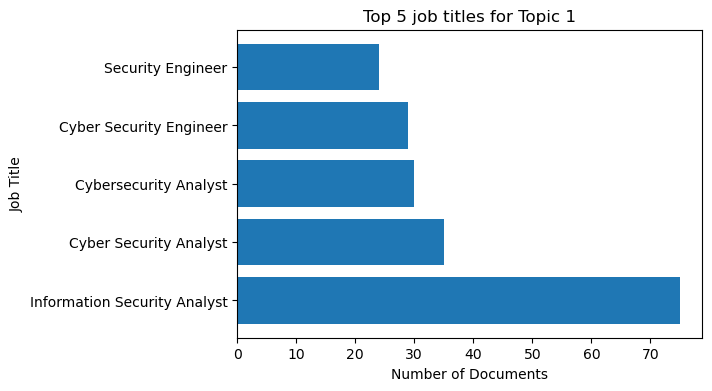

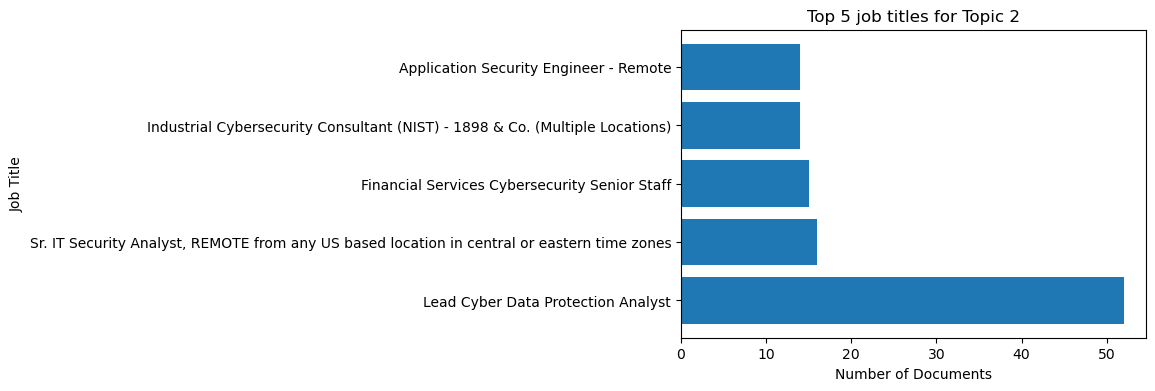

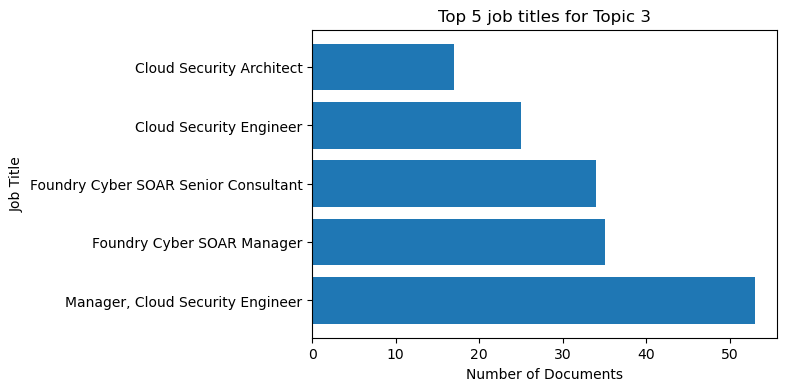

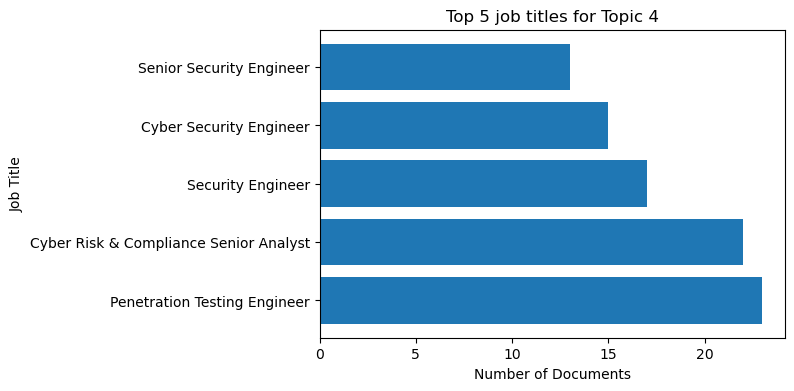

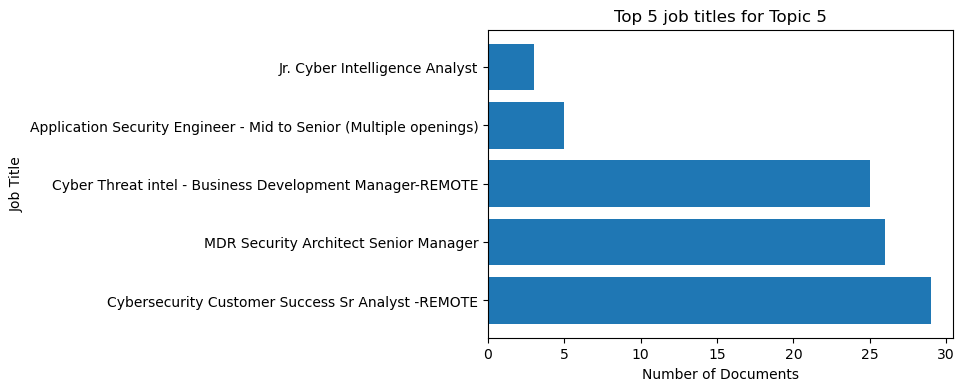

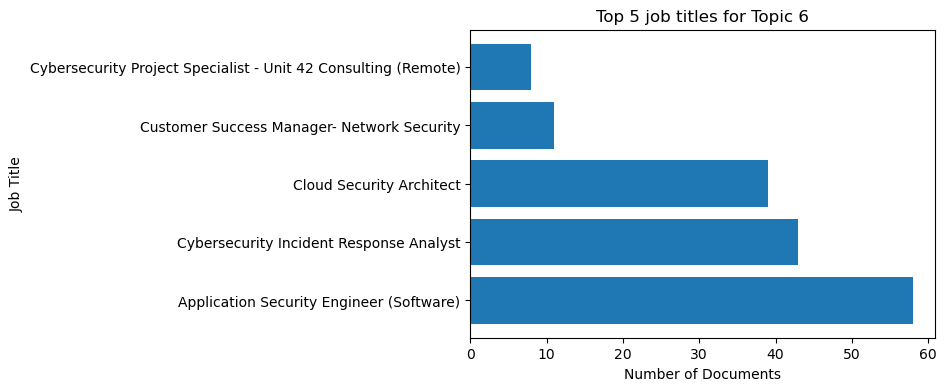

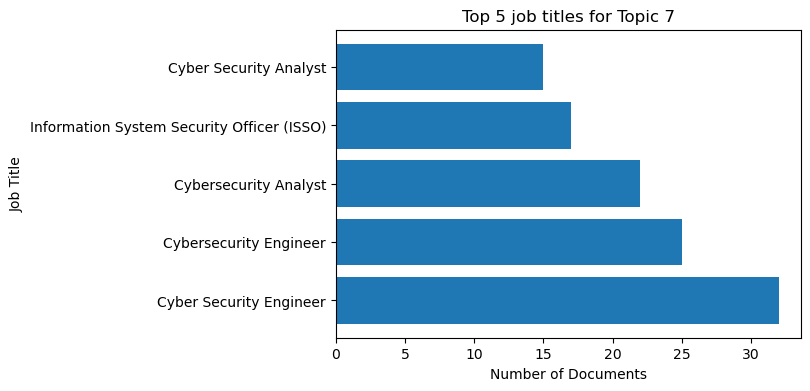

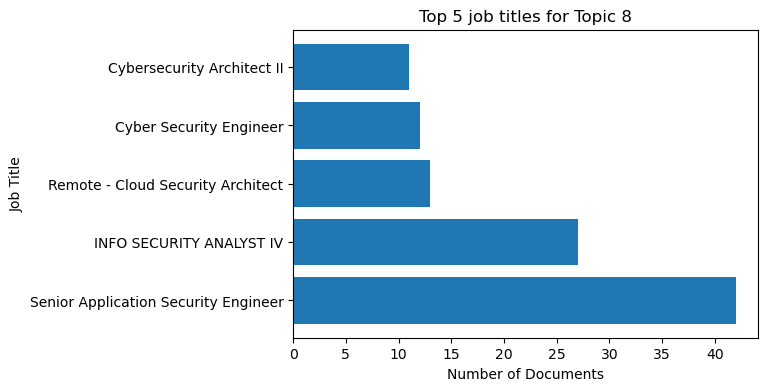

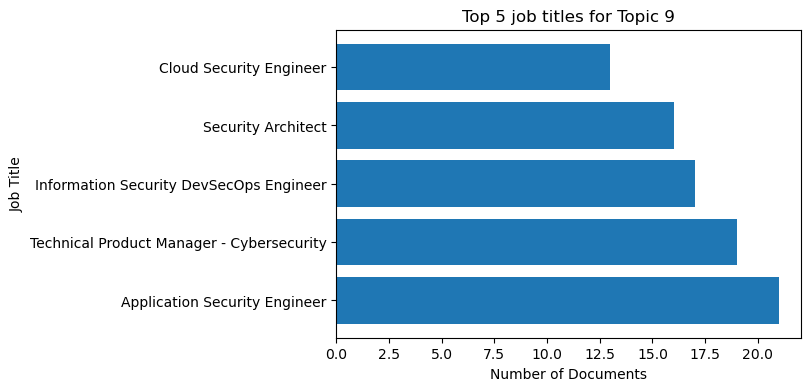

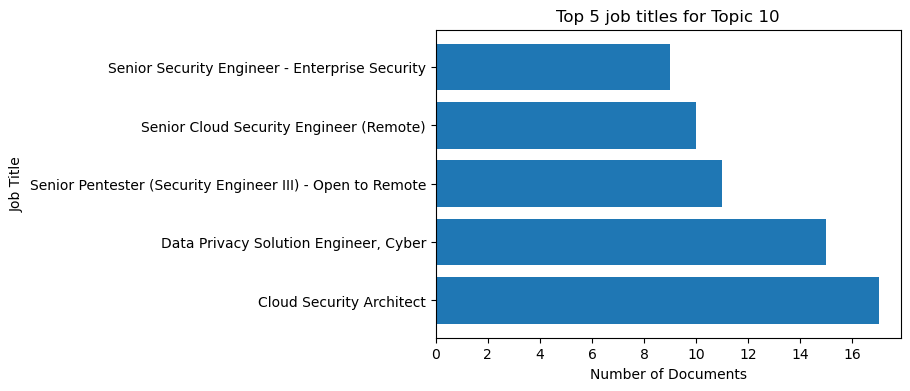

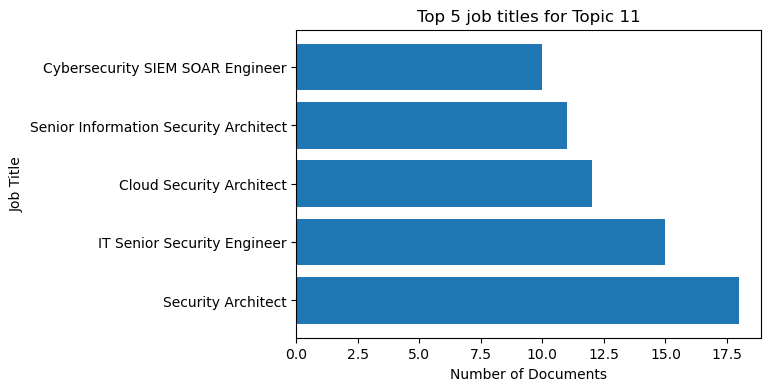

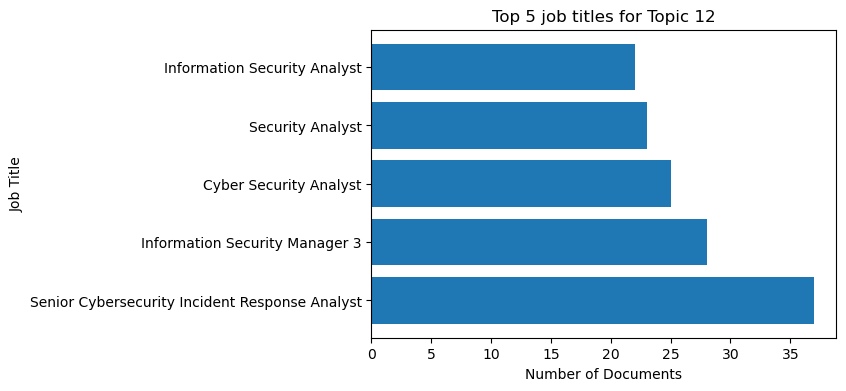

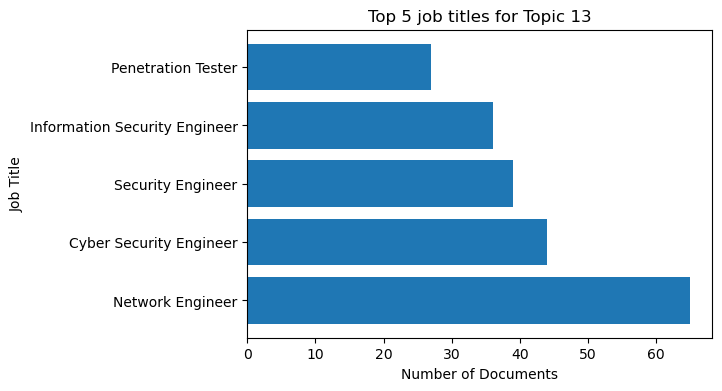

In [93]:
import matplotlib.pyplot as plt

# Get dominant topic for each document
dominant_topics = []
for i, doc in enumerate(corpus):
    topic = max(best_model[doc], key=lambda x: x[1])[0]
    dominant_topics.append(topic)

# Count number of documents per topic
topic_counts = [dominant_topics.count(i) for i in range(best_model.num_topics)]

# Get top 5 job titles for each topic
top_job_titles = []
for i in range(best_model.num_topics):
    topic_job_titles = {}
    for j, doc in enumerate(corpus):
        if dominant_topics[j] == i:
            job_title = df.iloc[j]['job_title']
            if job_title in topic_job_titles:
                topic_job_titles[job_title] += 1
            else:
                topic_job_titles[job_title] = 1
    sorted_job_titles = sorted(topic_job_titles.items(), key=lambda x: x[1], reverse=True)[:5]
    top_job_titles.append(sorted_job_titles)

# Create horizontal bar plots
for i in range(best_model.num_topics):
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    ax.barh([j for j in range(5)], [count for title, count in top_job_titles[i]], tick_label=[title for title, count in top_job_titles[i]])
    ax.set_title(f'Top 5 job titles for Topic {i+1}')
    ax.set_xlabel('Number of Documents')
    ax.set_ylabel('Job Title')
    plt.show()